In [4]:
# Data Processing
import pandas as pd
import numpy as np
import statistics as stat

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint,uniform
from sklearn.model_selection import RandomizedSearchCV

In [5]:
ft_t = pd.read_csv("./data-chandra-mw/x_phot.csv")
cl_t = pd.read_csv("./data-chandra-mw/id_frame.csv")

In [6]:
ft= ft_t.values[:,1:]

In [7]:
cl= cl_t.values[:,2]

In [8]:
def mode_impute(ft):
    l,b= ft.shape
    for i in range(b):
        ar= ft[:,i]
        temp=ar[np.invert(np.isnan(ar.astype(float)))]
        m=stat.mode(temp)
        for j in range(l):
            if np.isnan(ft[j,i]):
                ft[j,i]=m
    return ft

In [9]:
def normalise(ft):
    l,b= ft.shape
    for i in range(b):
        ft[:,i]= (ft[:,i]-np.min(ft[:,i]))/(np.max(ft[:,i])-np.min(ft[:,i]))
    return ft

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(cl)

LabelEncoder()

In [11]:
y=le.transform(cl)

In [12]:
ft=mode_impute(ft)

In [13]:
ft=normalise(ft)

In [15]:
rf= RandomForestClassifier()

In [18]:
param_dist = {'rf__n_estimators': randint(10,200),
              'rf__max_depth': randint(6,20),
            'rf__min_samples_leaf': randint(1,60),
             'rf__max_features': uniform(0.1,1.0)}

# Create a random forest classifier
rf = RandomForestClassifier()

#create pipeline
smote_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto',k_neighbors=4)),
    ('rf', rf)
])

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

#create scorer
from sklearn.metrics import make_scorer
scorer = make_scorer(recall_score, average = 'macro')

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(smote_pipeline, 
                                 param_distributions = param_dist, 
                                 n_iter=15, 
                                 cv=cv,scoring=scorer)

# Fit the random search object to the data
rand_search.fit(ft, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(k_neighbors=4)),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=15,
                   param_distributions={'rf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016062563A60>,
                                        'rf__max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000160625CDB10>,
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000160625CCFA0>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001606245B790>},
                   scoring=make_scorer(recall_score, average=macro))

In [19]:
# Create a variable for the best model
best_rf_smote = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'rf__max_depth': 15, 'rf__max_features': 0.5500811356354632, 'rf__min_samples_leaf': 11, 'rf__n_estimators': 67}


In [20]:
smote_pipeline_best = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto',k_neighbors=4)),
    ('rf', best_rf_smote)
])

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=20, shuffle=True)

# Train the LightGBM model using cross-validation with SMOTE
y_pred = cross_val_predict(smote_pipeline_best, ft, y,cv=cv)

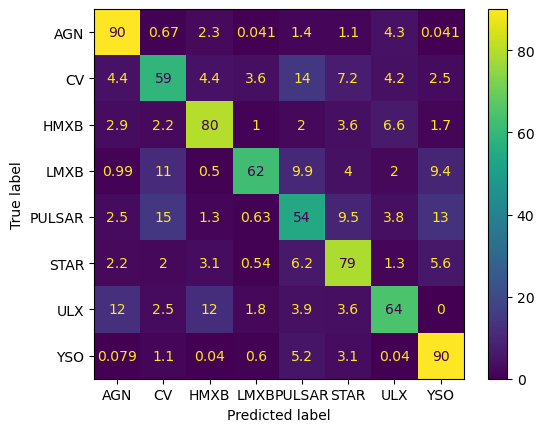

In [21]:
from sklearn.metrics import confusion_matrix
cf_matrix= confusion_matrix(y, y_pred)
cf_matrix= cf_matrix.astype('float64')
l=cf_matrix.shape[0]
for i in range(l):
    cf_matrix[i]=(cf_matrix[i]/np.sum(cf_matrix[i]))*100
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=le.classes_).plot()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y,y_pred,target_names=le.classes_))

              precision    recall  f1-score   support

         AGN       0.96      0.90      0.93      4907
          CV       0.49      0.59      0.53       360
        HMXB       0.69      0.80      0.74       862
        LMXB       0.64      0.62      0.63       202
      PULSAR       0.13      0.54      0.21       158
        STAR       0.94      0.79      0.86      4590
         ULX       0.34      0.64      0.44       281
         YSO       0.87      0.90      0.89      2520

    accuracy                           0.84     13880
   macro avg       0.63      0.72      0.65     13880
weighted avg       0.88      0.84      0.85     13880

